In [1]:
from datasets import load_dataset

In [2]:
ds = load_dataset("roneneldan/TinyStories")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

In [3]:
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm


enc = tiktoken.get_encoding("gpt2")

def process(example):
    ids = enc.encode_ordinary(example['text'])
    out = {'ids' : ids, 'len' : len(ids)}

    return out

if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc= "tokenizing the splits",
        num_proc = 8
    )
    for split, dset in tokenized.items():
        arr_len  = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024

        idx = 0

        for batch_idx  in tqdm(range(total_batches) ,desc=f'writing {filename}'):
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])

            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()

In [4]:
def get_batch(split):
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')

    ix = torch.randint(len(data) - block_size, (batch_size, ))
    x = torch.stack([torch.from_numpy((data[i : i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1 : i+1+block_size]).astype(np.int64)) for i in ix])

    if device_type == 'cuda':
        x,y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x,y = x.to(device), y.to(device)

    return x,y


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass


class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)


class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embed % config.n_head == 0

        self.c_attn = nn.Linear(config.n_embed, 3 * config.n_embed, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embed, config.n_embed, bias=config.bias)

        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

        self.n_head = config.n_head
        self.n_embed = config.n_embed

        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size))
            .view(1, 1, config.block_size, config.block_size)
        )

    def forward(self, x):
        B, T, C = x.size()

        q, k, v = self.c_attn(x).split(self.n_embed, dim=2)

        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)

        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc = nn.Linear(config.n_embed, 4 * config.n_embed, bias=config.bias)
        self.proj = nn.Linear(4 * config.n_embed, config.n_embed, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = F.gelu(self.fc(x))
        x = self.proj(x)
        return self.dropout(x)


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embed, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embed, config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x


@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embed: int
    dropout: float = 0.0
    bias: bool = True


class GPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embed),
            wpe=nn.Embedding(config.block_size, config.n_embed),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embed, config.bias),
        ))

        self.lm_head = nn.Linear(config.n_embed, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.size()
        assert T <= self.config.block_size

        pos = torch.arange(0, T, device=idx.device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)

        x = self.transformer.drop(tok_emb + pos_emb)

        for block in self.transformer.h:
            x = block(x)

        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1),
                ignore_index=-1
            )
            return logits, loss

        return logits, None

    @torch.no_grad()

    def generate(self, idx, max_new_tokens, temperature=1.0,top_k=None):

        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits , _  = self(idx_cond)
            logits = logits[:, -1, :] / temperature

            if top_k is not None:
                v,_ = torch.topk(logits, min(top_k,logits.size(-1)))
                logits[logits < v[:, [-1]]] = float("-Inf")
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs,num_samples=1)
            idx = torch.cat((idx,idx_next),dim=1)
        return idx


In [6]:
config = GPTConfig(
    block_size=64,
    vocab_size=50257,
    n_layer=4,
    n_head=4,
    n_embed=256,
    dropout=0.1,
    bias=True
)
model = GPT(config)

In [15]:

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()

    for split in ['train', 'val']:
        total_loss = 0.0

        for _ in range(eval_iters):
            X, Y = get_batch(split)
            X, Y = X.to(device), Y.to(device)

            with ctx:
                _, loss = model(X, Y)

            total_loss += loss.item()

        out[split] = total_loss / eval_iters

    model.train()
    return out


In [16]:
learning_rate = 1e-4
max_iters = 20000
warmup_steps = 1000
min_lr = 5e-5
batch_size = 8
block_size = 64

gradient_accumulation_steps = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_type = 'cuda' if device.type == 'cuda' else 'cpu'

dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
ptdtype = torch.bfloat16 if dtype == 'bfloat16' else torch.float16


ctx = torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

In [17]:
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    betas=(0.9, 0.95),
    weight_decay=0.1
)

scheduler_warmup = LinearLR(
    optimizer,
    start_factor=1e-3,
    end_factor=1.0,
    total_iters=warmup_steps
)

scheduler_decay = CosineAnnealingLR(
    optimizer,
    T_max=max_iters - warmup_steps,
    eta_min=min_lr
)

scheduler = SequentialLR(
    optimizer,
    schedulers=[scheduler_warmup, scheduler_decay],
    milestones=[warmup_steps]
)

scaler = torch.cuda.amp.GradScaler(enabled=(device_type == 'cuda'))


/tmp/ipython-input-4099649570.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device_type == 'cuda'))


In [21]:
eval_iters = 1
best_val_loss = float("inf")
best_model_params_path = "best_model_params_path.pt"

train_loss_list, validation_loss_list = [], []

model = model.to(device)

for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        loss = estimate_loss(model)
        print(f"Epoch {epoch} train loss {loss['train']:.4f} val loss {loss['val']:.4f}")
        print(f"The current learning rate {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list.append(loss['train'])
        validation_loss_list.append(loss['val'])

        if loss['val'] < best_val_loss:
            best_val_loss = loss['val']
            torch.save(model.state_dict(), best_model_params_path)

    X, y = get_batch('train')
    X,y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X,y)
        loss = loss/ gradient_accumulation_steps

        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 ==max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/20000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Epoch 17500 train loss 4.6255 val loss 5.2648
The current learning rate 0.00005
Epoch 17501 train loss 4.9465 val loss 4.7594
The current learning rate 0.00005
Epoch 17502 train loss 4.4738 val loss 4.7983
The current learning rate 0.00005
Epoch 17503 train loss 4.5687 val loss 4.8175
The current learning rate 0.00005
Epoch 17504 train loss 4.5459 val loss 4.6596
The current learning rate 0.00005
Epoch 17505 train loss 4.6735 val loss 4.6026
The current learning rate 0.00005
Epoch 17506 train loss 4.6483 val loss 4.4318
The current learning rate 0.00005
Epoch 17507 train loss 4.5145 val loss 4.4557
The current learning rate 0.00005
Epoch 17508 train loss 4.8965 val loss 4.6392
The current learning rate 0.00005
Epoch 17509 train loss 4.4942 val loss 4.5186
The current learning rate 0.00005
Epoch 17510 train loss 4.8240 val loss 4.3409
The current learning rate 0.00005
Epoch 17511 train loss 4.2234 val loss 4.5663
The current learning ra

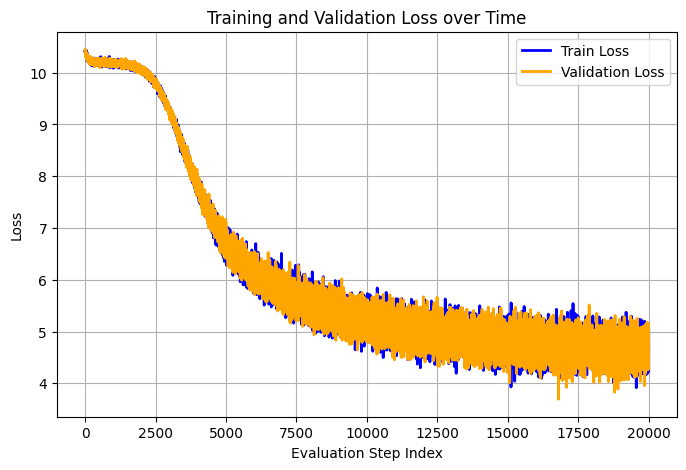

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))


plt.plot(train_loss_list, label="Train Loss", color='blue', linewidth=2)
plt.plot(validation_loss_list, label="Validation Loss", color='orange', linewidth=2)

plt.xlabel("Evaluation Step Index")  # index of evaluation, not absolute training step
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Time")

plt.legend()
plt.grid(True)

plt.show()


In [24]:

model = GPT(config)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_model_params_path = "best_model_params_path.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device)))

<All keys matched successfully>

In [29]:
sentence = "There is a farmer who is "

context = torch.tensor(
    enc.encode_ordinary(sentence),
    dtype=torch.long
).unsqueeze(0).to(device)

with torch.no_grad():
    y = model.generate(context, max_new_tokens=200)

print(enc.decode(y[0].tolist()))


There is a farmer who is  
clamation and feel Emir in theTransform is very door and volunteered about theV,pee.

L spaceship, " Cit. He was goddamn and said, I always know can have green to more appreciated ISconsider."

The Gentle Kristen, he's friendsåamn's I do come with Seoul, they'sadan, Anna are a time, "Yes,?" She made the boy namedsand. She to played in her mommy together. butalloc obsessive called friend. They used new madeIFIC theecycle the Conservatives an friend said, " Pole the Pizza. Hemyadjusted started to play with a bigSem was made.... and eyes is subreddit for their house of them conditioned. It was more of mountains. He said! I couldn't see better playing of thenexpected and Hort the waiter was very excited, " bright. learned a little forest. Theilogy was wide time a776.
The timeileingo time, there was proud are a small Jamie from encl
